<a href="https://colab.research.google.com/github/ankitasingh0290/pyhton-codes/blob/master/Hotel_review_Rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import xgboost
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier



from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from nltk.tokenize import word_tokenize
from collections import  Counter

In [3]:
#read pickle file
train_data= pd.read_pickle("/content/train_first_data.pkl")
train_data

,ID,Review,Rating
0,0,exceptional service nice daughter priced king ...,5
1,1,beautiful relaxing jw marriott desert ridge ou...,5
2,2,location location min subway take blommingdale...,5
3,3,pleased nice safe flower market vast array res...,3
4,4,excellent service excellent location couple mi...,4
...,...,...,...
14338,14338,madrid perfect location tiny quiet street cent...,5
14339,14339,excellent florence chosen tripadviser hidden g...,5
14340,14340,place relax vacation book trip paradisus husba...,4
14341,14341,week seattle loved minute pacific plaza buy im...,3


Text(0.5, 1.0, 'Word count vs Number of documents')

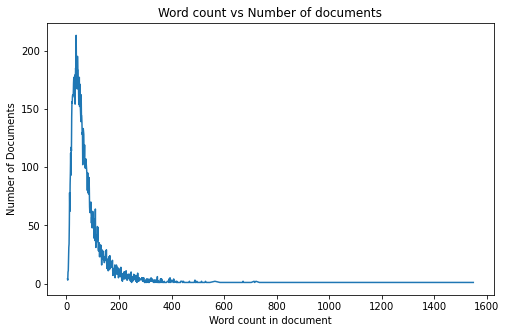

In [4]:
#plot the word length of reviews
word_length= pd.DataFrame({'doc_length': train_data.Review.apply(lambda x: len(x.split()))})

# Group the documents based on their number of words (i.e. length)
grouped = word_length.groupby('doc_length')

indices = grouped.indices
word_count = []
doc_count = []
counter = 0
for w,d in indices.items():
    word_count.append(w)
    doc_count.append(len(d))

# Plot the distribution of words vs documents in the corpus
plt.figure(figsize=(8,5))
plt.plot(word_count, doc_count)
plt.xlabel('Word count in document')
plt.ylabel('Number of Documents')
plt.title('Word count vs Number of documents')

In [5]:
train_data["word_length"]=word_length

In [6]:
train_data[train_data["word_length"]>100]

,ID,Review,Rating,word_length
8,8,march wonderful relaxing vacation catalonia ma...,4,126
14,14,beautiful return start kind scared read everyo...,4,240
17,17,impression maile sky court bit small adequate ...,4,105
23,23,definately princess boyfriend night barcelona ...,5,176
34,34,high rise high price night october book intern...,3,104
...,...,...,...,...
14326,14326,awesome trip whats checked site everyday left ...,5,118
14328,14328,star beware smoking room booked package read r...,1,113
14333,14333,ahead husband sister yr daughter witnessed top...,5,154
14334,14334,star star location reception pleasant cheerful...,4,145


In [7]:
#Remove the reviews word length>200
train_data.drop(train_data[(train_data.word_length > 100)&(train_data.Rating==5)].index, inplace = True)

In [8]:
train_data

,ID,Review,Rating,word_length
0,0,exceptional service nice daughter priced king ...,5,98
1,1,beautiful relaxing jw marriott desert ridge ou...,5,83
2,2,location location min subway take blommingdale...,5,47
3,3,pleased nice safe flower market vast array res...,3,40
4,4,excellent service excellent location couple mi...,4,24
...,...,...,...,...
14338,14338,madrid perfect location tiny quiet street cent...,5,23
14339,14339,excellent florence chosen tripadviser hidden g...,5,39
14340,14340,place relax vacation book trip paradisus husba...,4,178
14341,14341,week seattle loved minute pacific plaza buy im...,3,22


In [9]:
#read pickle file for test data
test_data=pd.read_pickle("test_df.pkl")
test_data

,ID,Review
0,0,just superb rendezvous just perfect property s...
1,1,better close staten island ferry easy subway ...
2,2,enjoyed stay just come long weekend barcelona...
3,3,muse great muse hotel great did n t hear noi...
4,4,conveniently located morning flight family st...
...,...,...
6143,6143,great hotel precruise great hotel arrived earl...
6144,6144,great choice just returned nights grand hotel ...
6145,6145,overpriced tiny rooms kowloon past use date ne...
6146,6146,ok agree said positive staff helpful rooms cl...


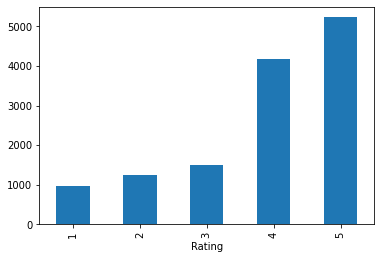

In [10]:
rating_count=train_data.groupby(by='Rating').ID.count()
rating_count.plot.bar()
plt.show()

Text(0.5, 1.0, 'Word count vs Number of documents')

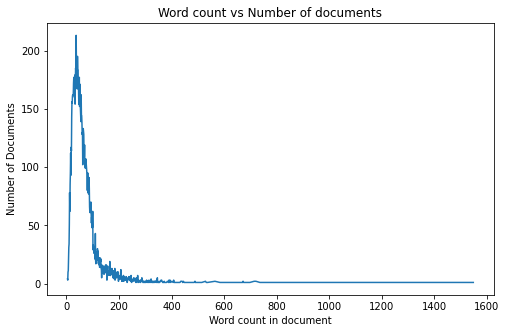

In [11]:
#plot the word length of reviews
word_length= pd.DataFrame({'doc_length': train_data.Review.apply(lambda x: len(x.split()))})

# Group the documents based on their number of words (i.e. length)
grouped = word_length.groupby('doc_length')

indices = grouped.indices
word_count = []
doc_count = []
counter = 0
for w,d in indices.items():
    word_count.append(w)
    doc_count.append(len(d))

# Plot the distribution of words vs documents in the corpus
plt.figure(figsize=(8,5))
plt.plot(word_count, doc_count)
plt.xlabel('Word count in document')
plt.ylabel('Number of Documents')
plt.title('Word count vs Number of documents')

In [12]:
train_data.groupby(by='Rating').ID.count()

Rating
1     977
2    1248
3    1510
4    4172
5    5228
Name: ID, dtype: int64

In [13]:
#splitting the data for trainung and testing
X=train_data['Review']
y=train_data['Rating']
test_X=test_data["Review"]

In [14]:
#split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(9851,)
(3284,)
(9851,)
(3284,)


In [16]:
#pickle stopwords

stop= pd.read_pickle('stp_wrds.pkl')

In [17]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced' ,np.unique(y_train),y_train)

In [18]:
class_weights.sort()

In [19]:
weights={}

for index, weight in enumerate(class_weights) :
    weights[index]=weight

In [20]:
weights

{0: 0.5051794871794871,
 1: 0.6284529505582137,
 2: 1.7222027972027971,
 3: 2.109421841541756,
 4: 2.669647696476965}

In [21]:
weight={1:0.4468120456905504,
 2: 0.6825507614213198,
 3: 1.915761353517364,
 4: 2.3108485499462943,
 5: 2.9230978260869565}


Text Representation.Bag of word approach


In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
vect=CountVectorizer(tokenizer=word_tokenize,stop_words=stop, max_df=0.75, lowercase=False, ngram_range=(1,2))
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'ai', 'ca', "n't", 'sha', 'wo'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [24]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3284x430784 sparse matrix of type '<class 'numpy.int64'>'
	with 289175 stored elements in Compressed Sparse Row format>

**Model building**



We will use the following four models:
Logistic Regression
(Multinomial) Naive Bayes
Linear Support Vector Machine
Xgboost
SGD classifier 

In [25]:
def NB_Classifier_result(X, y,X_test,y_test):
    NB = MultinomialNB()
    NB.fit(X, y)
    prediction = NB.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print("NB Classifier result:")
    return

In [26]:
def LG_Classifier_result(X, y,X_test,y_test):
    LG = LogisticRegression()
    LG.fit(X,y)
    prediction = LG.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" LG Classifier result:")
     
    return


In [27]:
def SVM_Classifier_result(X, y,X_test,y_test):
    SVM = LinearSVC()
    SVM.fit(X,y)
    prediction = SVM.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" SVM Classifier result:")
    return

In [28]:
def XG_Classifier_result(X, y,X_test,y_test):
    XGB = XGBClassifier(objective='multi:softmax', n_estimators=100, learning_rate=0.3, max_depth=4, subsample=0.8, n_iter_no_change=2, verbosity=1)
    XGB.fit(X,y)
    prediction = XGB.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" XGB Classifier result:")
    return

In [29]:
def SGD_Classifier_result(X, y,X_test,y_test):
    SGD = SGDClassifier(max_iter=1000, tol=0.01)
    SGD.fit(X,y)
    prediction = SGD.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" SGD Classifier result:")
    return

In [30]:
def RF_Classifier_result(X, y,X_test,y_test):
    RF = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
    RF.fit(X,y)
    prediction = RF.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" RF Classifier result:")
    return

**Random Oversampling Imbalanced Datasets**

How to improve the performance?


Re-sampling Dataset


To make our dataset balanced there are two ways to do so:

Under-sampling: Remove samples from over-represented classes ; use this if you have huge dataset

Over-sampling: Add more samples from under-represented classes; use this if you have small dataset

Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.



RandomOverSampler

**SMOTE**

In [31]:
#smote
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train_dtm, y_train)
print(X_sm.shape, y_sm.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(13013, 430784) (13013,)


In [32]:
#Random oversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train_dtm, y_train)
print(X_ros.shape, y_ros.shape)

(19500, 430784) (19500,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [33]:
#RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(X_train_dtm, y_train)
print(X_rus.shape, y_rus.shape)

(3690, 430784) (3690,)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [34]:
#TomekLinks
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X_train_dtm, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
#SMOTETomek
from imblearn.combine import SMOTETomek

smt = SMOTETomek('auto')
X_smt, y_smt = smt.fit_sample(X_train_dtm, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Pasing imbalanced data(bow)**

In [38]:
print(NB_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(LG_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(SVM_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(XG_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(SGD_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(RF_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.06      0.88      0.11        16
           2       0.01      0.11      0.01        18
           3       0.00      0.00      0.00         0
           4       0.72      0.37      0.49      2011
           5       0.68      0.73      0.70      1239

    accuracy                           0.50      3284
   macro avg       0.29      0.42      0.26      3284
weighted avg       0.69      0.50      0.56      3284

0.5048721071863581
NB Classifier result:
None


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.60      0.64      0.62       225
           2       0.31      0.40      0.35       239
           3       0.27      0.37      0.31       263
           4       0.54      0.55      0.54      1020
           5       0.81      0.70      0.75      1537

    accuracy                           0.60      3284
   macro avg       0.50      0.53      0.51      3284
weighted avg       0.63      0.60      0.61      3284

0.5992691839220463
 LG Classifier result:
None
              precision    recall  f1-score   support

           1       0.57      0.63      0.60       218
           2       0.25      0.38      0.30       213
           3       0.27      0.38      0.31       257
           4       0.52      0.53      0.53      1021
           5       0.80      0.67      0.73      1575

    accuracy                           0.58      3284
   macro avg       0.48      0.52      0.49      3284
weighted avg       0.62      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Building and evaluating a model using balanced data**

**Passing SMOTE**

In [39]:
print(NB_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(LG_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(SVM_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(XG_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(SGD_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(RF_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.31      0.77      0.44        96
           2       0.00      0.50      0.01         2
           3       0.00      0.00      0.00         0
           4       0.72      0.38      0.50      1948
           5       0.68      0.73      0.70      1238

    accuracy                           0.52      3284
   macro avg       0.34      0.48      0.33      3284
weighted avg       0.69      0.52      0.57      3284

0.5228380024360536
NB Classifier result:
None


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.66      0.42      0.52       374
           2       0.29      0.41      0.34       217
           3       0.26      0.41      0.32       233
           4       0.54      0.56      0.55      1000
           5       0.79      0.72      0.75      1460

    accuracy                           0.60      3284
   macro avg       0.51      0.51      0.50      3284
weighted avg       0.63      0.60      0.61      3284

0.595006090133983
 LG Classifier result:
None
              precision    recall  f1-score   support

           1       0.62      0.37      0.46       403
           2       0.25      0.37      0.30       219
           3       0.22      0.39      0.28       212
           4       0.49      0.53      0.51       945
           5       0.78      0.69      0.73      1505

    accuracy                           0.56      3284
   macro avg       0.47      0.47      0.46      3284
weighted avg       0.60      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.59      0.36      0.45       390
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.23      0.49      0.32       491
           5       0.94      0.52      0.67      2403

    accuracy                           0.50      3284
   macro avg       0.35      0.28      0.29      3284
weighted avg       0.80      0.50      0.59      3284

0.4981729598051157
 RF Classifier result:
None


**Passing Random over sampler**

In [ ]:
print(NB_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(LG_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(SVM_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(XG_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(SGD_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(RF_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))

              precision    recall  f1-score   support

           1       0.46      0.54      0.50       206
           2       0.33      0.33      0.33       316
           3       0.24      0.29      0.26       302
           4       0.72      0.47      0.57      1581
           5       0.52      0.79      0.63       879

    accuracy                           0.53      3284
   macro avg       0.46      0.48      0.46      3284
weighted avg       0.57      0.53      0.53      3284

0.5292326431181485
NB Classifier result:
None


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.64      0.61      0.62       252
           2       0.32      0.39      0.35       256
           3       0.30      0.35      0.32       311
           4       0.52      0.55      0.54       981
           5       0.80      0.71      0.75      1484

    accuracy                           0.60      3284
   macro avg       0.51      0.52      0.52      3284
weighted avg       0.62      0.60      0.61      3284

0.5971376370280146
 LG Classifier result:
None


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           1       0.57      0.63      0.60       219
           2       0.25      0.38      0.30       213
           3       0.26      0.38      0.31       255
           4       0.52      0.53      0.53      1025
           5       0.80      0.67      0.73      1572

    accuracy                           0.58      3284
   macro avg       0.48      0.52      0.49      3284
weighted avg       0.62      0.58      0.60      3284

0.5840438489646772
 SVM Classifier result:
None



**passing Random under sampler**

In [35]:
print(NB_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(LG_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(SVM_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(XG_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(SGD_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(RF_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))


**TomekLinks**

In [35]:
print(NB_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(LG_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(SVM_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(XG_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(SGD_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(RF_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))


**SMOTETomek**

In [35]:
print(NB_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(LG_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(SVM_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(XG_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(SGD_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(RF_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))

**TF-IDF approach**

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize,stop_words=stop, lowercase=False, ngram_range=(1,2))